In [9]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Load the dataset from the specified path
path = "/content/drive/MyDrive/Data/Twitter_Data.csv"
data = pd.read_csv(path)

# Drop rows with missing values (NaN) from the dataset
data.dropna(inplace=True)

# Drop duplicate rows based on the 'clean_text' column
data.drop_duplicates(subset=['clean_text'], inplace=True)

# Extract texts and labels from the cleaned dataset
texts = data['clean_text'].values
labels = data['category'].values

# Split data into training and validation sets
train_texts, val_texts, train_labels, val_labels = train_test_split(texts, labels, test_size=0.2, random_state=42)

In [10]:
from sklearn.preprocessing import LabelEncoder

# Initialize the label encoder
label_encoder = LabelEncoder()

# Fit and transform the labels
encoded_labels_train = label_encoder.fit_transform(train_labels)

# Save the mapping between original labels and encoded labels
label_mapping = {original_label: int_label for original_label, int_label in zip(train_labels, encoded_labels_train)}
label_mapping

{1.0: 2, 0.0: 1, -1.0: 0}

In [11]:
from sklearn.preprocessing import LabelEncoder

# Initialize the label encoder
label_encoder = LabelEncoder()

# Fit and transform the labels
encoded_labels_valid = label_encoder.fit_transform(val_labels)

# Save the mapping between original labels and encoded labels
label_mapping = {original_label: int_label for original_label, int_label in zip(val_labels, encoded_labels_valid)}
label_mapping

{0.0: 1, 1.0: 2, -1.0: 0}

In [12]:
# Import the necessary classes from the transformers library
from transformers import RobertaTokenizer, RobertaForSequenceClassification

# Initialize a tokenizer using the 'roberta-base' pre-trained model
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')

# Initialize a model for sequence classification using the 'roberta-base' pre-trained weights
# Set the number of labels to 3 (positive, negative and neutral)
model = RobertaForSequenceClassification.from_pretrained('roberta-base', num_labels=3)

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [13]:
from torch.utils.data import Dataset, DataLoader

# Define a custom Dataset class for sentiment classification
class Sentiment(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]

        # Tokenize and encode the text using the provided tokenizer
        encoding = self.tokenizer.encode_plus(
            text,
            truncation=True,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            pad_to_max_length=True,
            return_attention_mask=True,
            return_tensors='pt',
        )

        # Return a dictionary containing tokenized data and label
        return {
            'text': text,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

# Use the encoded labels
train_labels = encoded_labels_train
val_labels = encoded_labels_valid

# Create Sentiment instances for training and validation data
train_data = Sentiment(train_texts, train_labels, tokenizer, max_len=128)
val_data = Sentiment(val_texts, val_labels, tokenizer, max_len=128)

# Create DataLoader instances for training and validation data
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader = DataLoader(val_data, batch_size=32)

In [14]:
# Import the AdamW optimizer class from the transformers library
from transformers import AdamW

# Initialize the AdamW optimizer with the parameters of the model
# Set the learning rate (lr) to 1e-5
optimizer = AdamW(model.parameters(), lr=1e-5)

In [15]:
import torch
from sklearn.metrics import accuracy_score

# Check if CUDA (GPU) is available, and move the model to the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Loop over training epochs (here, only 1 epoch as training time is too long for a single epoch)
for epoch in range(1):
    print(f"Epoch {epoch + 1} / {1}")
    model.train()  # Set the model to training mode

    # Track progress for training
    total_batches = len(train_loader)
    total_rows = sum(len(batch['input_ids']) for batch in train_loader)  # Total rows in the training set
    processed_rows = 0  # Initialize processed rows counter

    for batch_idx, batch in enumerate(train_loader, start=1):
        optimizer.zero_grad()  # Clear gradients
        input_ids = batch['input_ids'].to(device)  # Move input to the device
        attention_mask = batch['attention_mask'].to(device)  # Move attention mask to the device
        labels = batch['labels'].to(device)  # Move labels to the device
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)  # Forward pass
        loss = outputs[0]  # Get the loss
        loss.backward()  # Backpropagation
        optimizer.step()  # Update model parameters using gradients

        # Update processed rows
        processed_rows += len(batch['input_ids'])
        progress = (processed_rows / total_rows) * 100
        print(f"Training: {progress:.2f}% complete ({processed_rows}/{total_rows} rows)", end="\r")

    print("\nTraining epoch completed.")  # Print a message to indicate completion of an epoch

    # Validation loop
    model.eval()  # Set the model to evaluation mode
    val_loss = 0
    val_accuracy = 0

    # Track progress for validation
    total_val_batches = len(val_loader)
    total_val_rows = sum(len(batch['input_ids']) for batch in val_loader)  # Total rows in the validation set
    processed_val_rows = 0  # Initialize processed validation rows counter

    for batch_idx, batch in enumerate(val_loader, start=1):
        with torch.no_grad():
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs[0]
            val_loss += loss.item()

            # Calculate accuracy
            logits = outputs.logits
            predictions = torch.argmax(logits, dim=1)
            accuracy = accuracy_score(labels.cpu(), predictions.cpu())
            val_accuracy += accuracy

            # Update processed validation rows
            processed_val_rows += len(batch['input_ids'])
            progress = (processed_val_rows / total_val_rows) * 100
            print(f"Validation: {progress:.2f}% complete ({processed_val_rows}/{total_val_rows} rows)", end="\r")

    val_loss /= total_val_batches  # Calculate average validation loss
    val_accuracy /= total_val_batches  # Calculate average validation accuracy
    print(f"\nValidation Loss: {val_loss:.4f} and Validation Accuracy: {val_accuracy:.4f}")


Epoch 1 / 1
Training: 100.00% complete (130375/130375 rows)
Training epoch completed.
Validation: 100.00% complete (32594/32594 rows)
Validation Loss: 0.1496 and Validation Accuracy: 0.9536


In [18]:
import pandas as pd

# Load the dataset from the specified path
reddit = pd.read_csv('/content/drive/MyDrive/Data/Reddit_Data.csv')

# Rename the 'clean_comment' column to 'clean_text'
reddit.rename(columns={'clean_comment': 'clean_text'}, inplace=True)

# Drop rows with missing values (NaN) from the dataset
reddit.dropna(inplace=True)

# Drop duplicate rows based on the 'clean_text' column
reddit.drop_duplicates(subset=['clean_text'], inplace=True)

# Reset the index after dropping rows
reddit.reset_index(drop=True, inplace=True)

# Print the cleaned test data
reddit

,clean_text,category
0,family mormon have never tried explain them t...,1
1,buddhism has very much lot compatible with chr...,1
2,seriously don say thing first all they won get...,-1
3,what you have learned yours and only yours wha...,0
4,for your own benefit you may want read living ...,1
...,...,...
36794,jesus,0
36795,kya bhai pure saal chutiya banaya modi aur jab...,1
36796,downvote karna tha par upvote hogaya,0
36797,haha nice,1


In [19]:
from torch.utils.data import DataLoader

# Transform the labels of the test data using the label encoder
test_enc_labels = label_encoder.transform(reddit['category'])

# Create a test dataset using the Sentiment class we defined earlier
test_dataset = Sentiment(reddit['clean_text'], test_enc_labels, tokenizer, max_len=128)

# Create a DataLoader for the test dataset
# DataLoader helps manage batches and shuffling of data during testing
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

In [20]:
model.eval()  # Set the model to evaluation mode

# Lists to store predicted and true labels
all_predictions = []
all_true_labels = []

# Disable gradient calculation for inference
with torch.no_grad():
    for batch in test_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        # Perform forward pass
        outputs = model(input_ids, attention_mask=attention_mask)
        predictions = torch.argmax(outputs.logits, dim=1)

        # Extend the lists with predicted and true labels
        all_predictions.extend(predictions.cpu().numpy())
        all_true_labels.extend(labels.cpu().numpy())

# Convert encoded predictions back to original labels using the label encoder
predicted_labels = label_encoder.inverse_transform(all_predictions)
true_labels = label_encoder.inverse_transform(all_true_labels)

In [21]:
from sklearn.metrics import accuracy_score, classification_report

# Calculate accuracy using true_labels and predicted_labels
accuracy = accuracy_score(true_labels, predicted_labels)
print(f'Accuracy: {accuracy}')

# Generate a classification report using true_labels and predicted_labels
report = classification_report(true_labels, predicted_labels)
print('Classification Report: ')
print(report)

Accuracy: 0.9324709910595397
Classification Report: 
              precision    recall  f1-score   support

        -1.0       0.87      0.88      0.88      8250
         0.0       0.95      0.97      0.96     12778
         1.0       0.95      0.93      0.94     15771

    accuracy                           0.93     36799
   macro avg       0.92      0.93      0.93     36799
weighted avg       0.93      0.93      0.93     36799



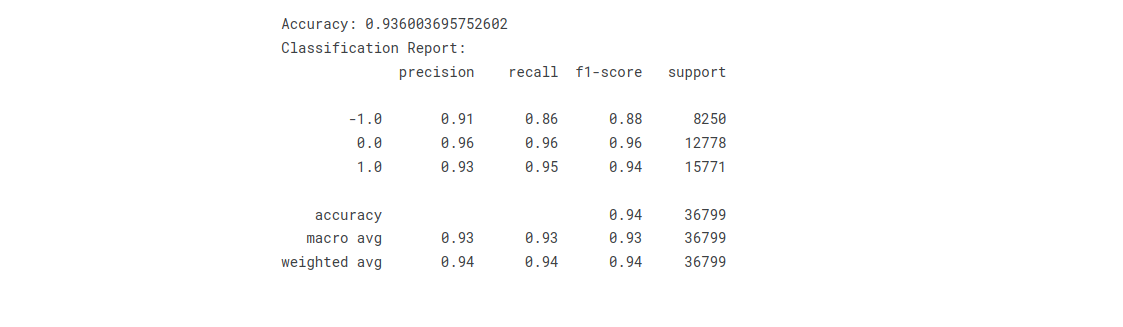

In [22]:
# Save the state dictionary of the model to the specified file
torch.save(model.state_dict(), 'Pre-trained-Sentiment.pth')

In [30]:
class SentimentPipeline:
    def __init__(self, model, tokenizer, max_len=128, device=None):
        """
        Initialize the custom sentiment pipeline.

        Args:
            model: The pre-trained model for sequence classification.
            tokenizer: Tokenizer corresponding to the pre-trained model.
            max_len: Maximum sequence length for input texts.
            device: Device to run the model on (e.g., 'cuda' or 'cpu').
        """
        self.model = model
        self.tokenizer = tokenizer
        self.max_len = max_len
        self.device = device if device else ("cuda" if torch.cuda.is_available() else "cpu")
        self.model.to(self.device)
        self.model.eval()  # Set the model to evaluation mode

        # Define sentiment labels
        self.labels = {0: "Negative", 1: "Neutral", 2: "Positive"}

    def predict(self, texts):
        """
        Predict sentiments for a list of input texts.

        Args:
            texts: List of input text strings.

        Returns:
            List of tuples containing text and its predicted sentiment label.
        """
        encoded = self.tokenizer(
            texts,
            padding=True,
            truncation=True,
            max_length=self.max_len,
            return_tensors='pt'
        )
        input_ids = encoded['input_ids'].to(self.device)
        attention_mask = encoded['attention_mask'].to(self.device)

        with torch.no_grad():
            outputs = self.model(input_ids=input_ids, attention_mask=attention_mask)
            predictions = torch.argmax(outputs.logits, dim=1).cpu().tolist()

        # Pair texts with sentiment labels
        results = [(text, self.labels[pred]) for text, pred in zip(texts, predictions)]
        return results

    def __call__(self, texts):
        """
        Allow the pipeline to be called as a function for convenience.

        Args:
            texts: List of input text strings.

        Returns:
            List of tuples containing text and its predicted sentiment label.
        """
        return self.predict(texts)


# Instantiate the custom pipeline
pipeline = SentimentPipeline(model=model, tokenizer=tokenizer, max_len=128)

# Example usage
custom_texts = [
    # Positive Sentiments
    "I absolutely loved the way the staff treated us. It was a fantastic experience!",
    "The product exceeded my expectations. Totally worth the money!",
    "What a beautiful day! The weather is perfect, and everything feels amazing.",

    # Negative Sentiments
    "The service was terrible, and the staff was rude. I wouldn’t recommend this place.",
    "I regret buying this. It broke within two days of use.",
    "This is by far the worst experience I’ve had in years.",

    # Neutral Sentiments
    "The event was fine, nothing too great or terrible to mention.",
    "It’s an average product; I don’t have much to say about it.",
    "I attended the meeting and left after an hour. It was okay, I guess.",

    # Mixed Sentiments
    "The hotel had good amenities, but the food was disappointing.",
    "I enjoyed the story, but the acting was subpar in some parts.",
    "The package arrived early, but it was damaged. Mixed feelings about the service.",

    # Sarcasm and Ambiguity
    "Oh great, another delay. Just what I needed today.",
    "Wow, the movie was so good I fell asleep halfway through it.",
    "The restaurant serves the best cold coffee—literally, it arrived cold and stale.",

    # Robustness Check: Contextual Sentiments
    "The support team resolved my issue quickly, but it shouldn’t have happened in the first place.",
    "The app has excellent features, but it crashes all the time.",
    "I love the concept, but the execution leaves much to be desired.",

    # Sentiment Shift in Text
    "Initially, I was disappointed with the service, but they quickly fixed everything, and now I’m happy.",
    "It started great, but then it went downhill after the main character left."

]

predictions = pipeline(custom_texts)

# Display results
for text, sentiment in predictions:
    print(f"Text: {text}\nSentiment: {sentiment}\n")


Text: I absolutely loved the way the staff treated us. It was a fantastic experience!
Sentiment: Positive

Text: The product exceeded my expectations. Totally worth the money!
Sentiment: Positive

Text: What a beautiful day! The weather is perfect, and everything feels amazing.
Sentiment: Positive

Text: The service was terrible, and the staff was rude. I wouldn’t recommend this place.
Sentiment: Negative

Text: I regret buying this. It broke within two days of use.
Sentiment: Neutral

Text: This is by far the worst experience I’ve had in years.
Sentiment: Negative

Text: The event was fine, nothing too great or terrible to mention.
Sentiment: Negative

Text: It’s an average product; I don’t have much to say about it.
Sentiment: Negative

Text: I attended the meeting and left after an hour. It was okay, I guess.
Sentiment: Positive

Text: The hotel had good amenities, but the food was disappointing.
Sentiment: Negative

Text: I enjoyed the story, but the acting was subpar in some parts